# Modeling

---

## Importing Libraries and Loading Data

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import catboost as cb

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tfl

import mlflow

import os

%matplotlib inline

In [50]:
df = pd.read_csv('../data/processed/sales_processed.csv')
list(df.columns)

['X1_sales_in_vol',
 'X2_sales_in_val',
 'X3_sales',
 'X4_turnover',
 'X5_value',
 'X1_sales_in_vol_disc',
 'X2_sales_in_val_disc',
 'X3_sales_disc',
 'X4_turnover_disc',
 'X5_value_disc',
 'X6_sign_AUCHAN',
 'X6_sign_CARREFOUR',
 'X6_sign_CARREFOUR MARKET',
 'X6_sign_CASINO',
 'X6_sign_CORA',
 'X6_sign_GEANT',
 'X6_sign_INTERMARCHE',
 'X6_sign_LECLERC',
 'X6_sign_MONOPRIX',
 'X6_sign_OTHERS',
 'X6_sign_SIMPLY MARKET',
 'X6_sign_SUPER U',
 'X7_feature_Feat',
 'X7_feature_No_Feat',
 'Y_display']

In [51]:
df['Y_display'] = (df['Y_display']=='Displ').astype(int)
df['Y_display'].value_counts()

Y_display
0    13000
1    12782
Name: count, dtype: int64

In [52]:
X, y = df.drop('Y_display', axis=1), df['Y_display']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

---

## Modeling

### Metrics

For this particular problem, we are interested in minimizing the number of false positives (or the risk), for this reason we will create two custom metrics from the confusion matrix.

$precision\_risk = \frac{FP}{FP + TN}$

$recall\_risk = \frac{FP}{FP + TP}$

In [53]:
def precision_risk(cm):
    return cm[0,1] / (cm[0,1] + cm[0,0])

def recall_risk(cm):
    return cm[0,1] / (cm[0,1] + cm[1,1])

def f1_risk(cm):
    return 2 * precision_risk(cm) * recall_risk(cm) / (precision_risk(cm) + recall_risk(cm))

def train_and_evaluate(model, X_train, X_test, y_train, y_test, show_train=True, show_report=True, show_cm=True):
    # train model
    model.fit(X_train, y_train)

    # evaluate on train set
    print('Train set:')
    y_pred_train = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(f'Train Precision risk: {precision_risk(cm_train)}')
    print(f'Train Recall risk: {recall_risk(cm_train)}')
    print(f'Train F1 risk: {f1_risk(cm_train)}')
    print(classification_report(y_train, y_pred_train))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
    plt.show()
    
    # evaluate on test set
    print('Test set:')
    y_pred_test = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    pr_risk, rc_risk, fo_risk = precision_risk(cm_test), recall_risk(cm_test), f1_risk(cm_test)
    print(f'Test Precision risk: {pr_risk}')
    print(f'Test Recall risk: {rc_risk}')
    print(f'Test F1 risk: {fo_risk}')
    print(classification_report(y_test, y_pred_test))
    ConfusionMatrixDisplay(cm_test).plot()
    plt.show()
    
    # return metrics for mlflow logging
    return pr_risk, rc_risk, fo_risk

### Models

We'll try the following models:
- Logistic Regression
  - With L1 regularization
  - With L2 regularization
  - PLS
- K Nearest Neighbors
- Non Linear SVM
- Decision Tree
- Random Forest
- Gradient Boosting
- Neural Network

In MLFlow, we will create a new experiment for each model, and we will log the following:
- Hyperparameters
- Metrics (precision_risk, recall_risk, f1_risk)
- Model

In [55]:
# separate continuous from discretized features
features = list(X.columns[:5]) + list(X.columns[10:])
features_disc = list(X.columns[5:])
features

['X1_sales_in_vol',
 'X2_sales_in_val',
 'X3_sales',
 'X4_turnover',
 'X5_value',
 'X6_sign_AUCHAN',
 'X6_sign_CARREFOUR',
 'X6_sign_CARREFOUR MARKET',
 'X6_sign_CASINO',
 'X6_sign_CORA',
 'X6_sign_GEANT',
 'X6_sign_INTERMARCHE',
 'X6_sign_LECLERC',
 'X6_sign_MONOPRIX',
 'X6_sign_OTHERS',
 'X6_sign_SIMPLY MARKET',
 'X6_sign_SUPER U',
 'X7_feature_Feat',
 'X7_feature_No_Feat']

In [40]:
mlflow.set_tracking_uri('http://127.0.0.1:8080')

### Logistic Regression

We'll start simple, then raise the complexity of each model.

In [26]:
# mlflow.create_experiment('Logistc_Regression', tags={'mlflow.note.content': 'Models based on logistic regression'})
mlflow.set_experiment('Logistc_Regression')

<Experiment: artifact_location='mlflow-artifacts:/266469295848679742', creation_time=1706083046814, experiment_id='266469295848679742', last_update_time=1706083046814, lifecycle_stage='active', name='Logistc_Regression', tags={'mlflow.note.content': 'Models based on logistic regression'}>

Train set:
Train Precision risk: 0.11305014862402915
Train Recall risk: 0.15343571056741281
Train F1 risk: 0.1301827416772484
              precision    recall  f1-score   support

           0       0.71      0.89      0.79     10429
           1       0.85      0.64      0.73     10196

    accuracy                           0.76     20625
   macro avg       0.78      0.76      0.76     20625
weighted avg       0.78      0.76      0.76     20625



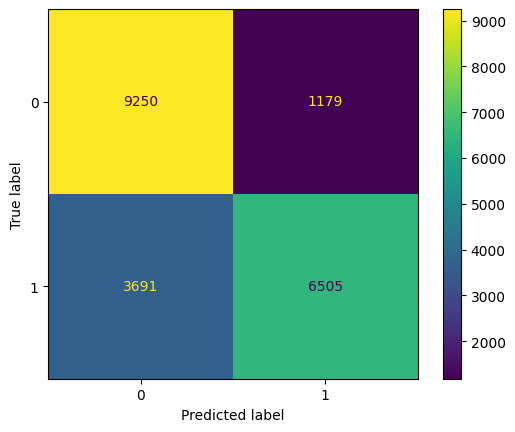

Test set:
Test Precision risk: 0.11901983663943991
Test Recall risk: 0.15315315315315314
Test F1 risk: 0.13394615889691397
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      2571
           1       0.85      0.65      0.74      2586

    accuracy                           0.77      5157
   macro avg       0.78      0.77      0.76      5157
weighted avg       0.78      0.77      0.76      5157



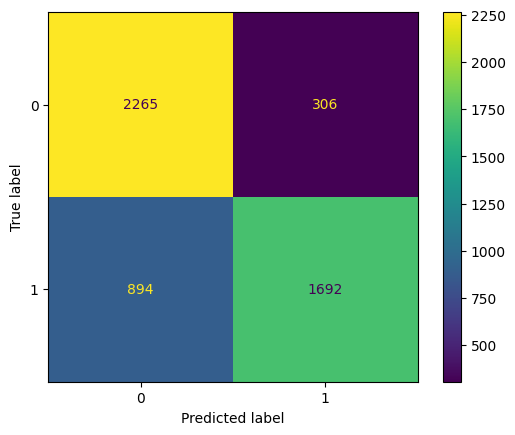

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'logreg_v1' already exists. Creating a new version of this model...
2024/01/24 09:01:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 s

In [28]:
logreg_v1_params = {
    'random_state': 42
}
logreg_v1 = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(**logreg_v1_params))
])

cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v1, train, test, y_train, y_test)

with mlflow.start_run():
    # log the parameters
    mlflow.log_params(logreg_v1_params)
    # log the metrics
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    # set the tags
    mlflow.set_tags({'Version': 'v1', 'Features': cols,'mlflow.note.content': 'Logistic Regression using the default parameters on the continuous features'})
    # log the model
    mlflow.sklearn.log_model(sk_model=logreg_v1, artifact_path='lr',input_example=train, registered_model_name='logreg_v1')

Our model doesn't overfit the data, we see a similar performance between the train and test set.  
15% of the positive predictions are missclassifier.

In [29]:
pd.DataFrame(logreg_v1.named_steps['logreg'].coef_, columns=cols).T.sort_values(by=0, ascending=False)

,0
X7_feature_Feat,1.315092
X6_sign_CASINO,0.981777
X6_sign_GEANT,0.602481
X2_sales_in_val,0.372983
X5_value,0.285411
X1_sales_in_vol,0.228050
X6_sign_INTERMARCHE,0.110970
X6_sign_MONOPRIX,0.009174
X6_sign_CARREFOUR,0.007269
X6_sign_CARREFOUR MARKET,-0.115271


- Coefficients associated with the categorical feature `X7` have a higher magnitude.
- We saw from the histograms of the MDLPC bins that high values for `X3` are associated with higher chances of the positive class, meaning that the coefficient for `X3` should be positive. However, it is negative, this is because there is a high correlation between `X3`, `X1` and `X2`. The ponalization that is implemented in the logistic regression model by default does a good job in reducing the magnitude of the coefficients for the correlated features.

Train set:
Train Precision risk: 0.08581839102502636
Train Recall risk: 0.12789368390968847
Train F1 risk: 0.10271417914730016
              precision    recall  f1-score   support

           0       0.70      0.91      0.79     10429
           1       0.87      0.60      0.71     10196

    accuracy                           0.76     20625
   macro avg       0.79      0.76      0.75     20625
weighted avg       0.78      0.76      0.75     20625



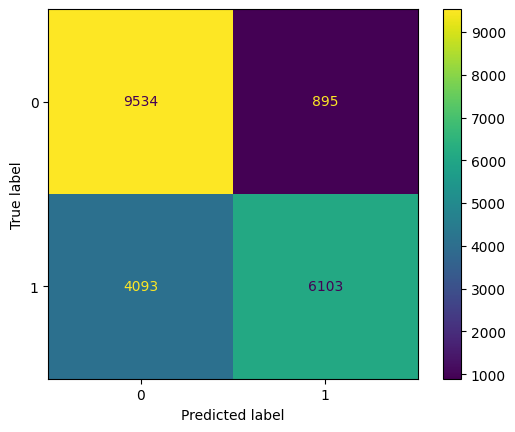

Test set:
Test Precision risk: 0.09684947491248541
Test Recall risk: 0.13495934959349593
Test F1 risk: 0.11277173913043477
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      2571
           1       0.87      0.62      0.72      2586

    accuracy                           0.76      5157
   macro avg       0.78      0.76      0.75      5157
weighted avg       0.78      0.76      0.75      5157



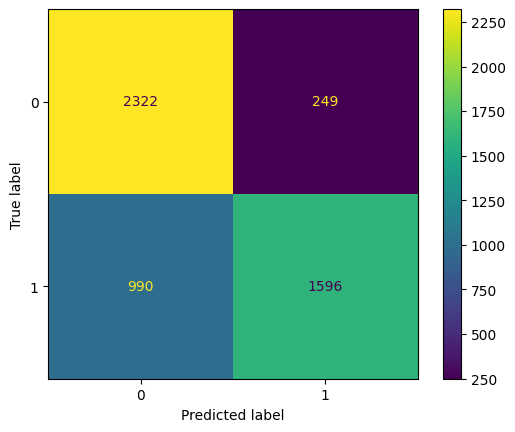

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'logreg_v2' already exists. Creating a new version of this model...
2024/01/24 09:03:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 s

In [30]:
logreg_v2_params = {
    'penalty': 'l1',
    'solver': 'liblinear',
    'C': 0.01,
    'random_state': 42
}
logreg_v2 = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(**logreg_v2_params))
])
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v2, train, test, y_train, y_test)

with mlflow.start_run():
    # log the parameters
    mlflow.log_params(logreg_v2_params)
    # log the metrics
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    # set the tags
    mlflow.set_tags({'Version': 'v2', 'Features': cols,'mlflow.note.content': 'Logistic Regression with L1 penalty on the continuous features'})
    # log the model
    mlflow.sklearn.log_model(sk_model=logreg_v2, artifact_path='lr',input_example=train, registered_model_name='logreg_v2')

Lasso regularization leads to a better performing model than the Ridge.  
The regularization parameter `C` is set to 1 by default, the lower its value, the lower the risk, but we can't afford to lower it too much since we risk to have a model that doesn't do any good at predicting the positive label.

In [31]:
pd.DataFrame(logreg_v2.named_steps['logreg'].coef_, columns=cols).T.sort_values(by=0, ascending=False)

,0
X6_sign_CASINO,0.817528
X2_sales_in_val,0.287564
X5_value,0.221130
X1_sales_in_vol,0.115370
X7_feature_Feat,0.064060
X6_sign_INTERMARCHE,0.000000
X6_sign_SUPER U,0.000000
X6_sign_SIMPLY MARKET,0.000000
X6_sign_OTHERS,0.000000
X6_sign_MONOPRIX,0.000000


Most features associated with the `X6` feature are set to 0 by the Lasso regularization, the feature `X3` as well.

#### Using Discritized Variables 

Train set:
Train Precision risk: 0.14066545210470802
Train Recall risk: 0.18180691535506258
Train F1 risk: 0.15861174180992538
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     10429
           1       0.82      0.65      0.72     10196

    accuracy                           0.75     20625
   macro avg       0.77      0.75      0.75     20625
weighted avg       0.77      0.75      0.75     20625



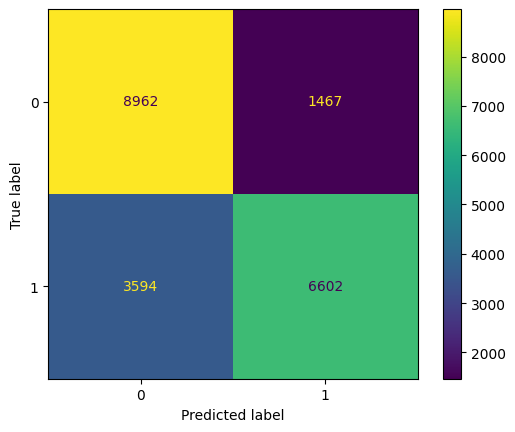

Test set:
Test Precision risk: 0.147024504084014
Test Recall risk: 0.1827852998065764
Test F1 risk: 0.16296615649924553
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      2571
           1       0.82      0.65      0.73      2586

    accuracy                           0.75      5157
   macro avg       0.76      0.75      0.75      5157
weighted avg       0.76      0.75      0.75      5157



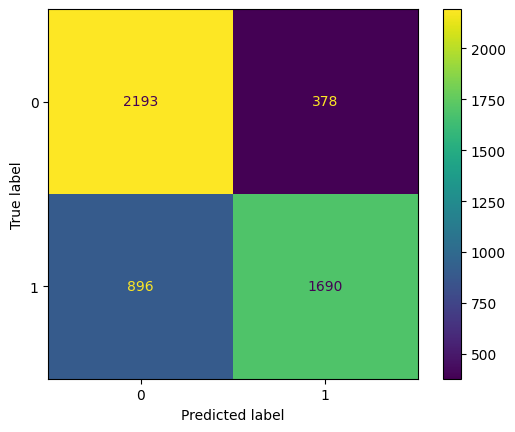

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'logreg_v3' already exists. Creating a new version of this model...
2024/01/24 09:05:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 s

In [32]:
logreg_v3_params = {'random_state': 42}
logreg_v3 = LogisticRegression(**logreg_v3_params)

cols = features_disc
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v3, train, test, y_train, y_test)

with mlflow.start_run():
    # log the parameters
    mlflow.log_params(logreg_v3_params)
    # log the metrics
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    # set the tags
    mlflow.set_tags({'Version': 'v3', 'Features': cols,'mlflow.note.content': 'Default logistic regression model the discretized features'})
    # log the model
    mlflow.sklearn.log_model(sk_model=logreg_v3, artifact_path='lr',input_example=train, registered_model_name='logreg_v3')

This new version of the model using the discretized variables has an equal overall performance to the previous model (in terms of the accuracy of the model). However, given the evaluation criterion that we are more interested in, which is reducing the risk, this model has more false positives, and less false negatives, meaning that the previous model is better at reducing the risk.  
This behaviour can be changed easily using a different threshold for the predicted probabilities.  
Given this fact, we can say that it is possible to obtain a model that is so much simpler using the discretized features, with a similar performance and more generalization power.

In [34]:
pd.DataFrame(logreg_v3.coef_, columns=cols).T.sort_values(by=0, ascending=False)

,0
X7_feature_Feat,1.283333
X6_sign_CASINO,1.056147
X6_sign_GEANT,0.653730
X2_sales_in_val_disc,0.382303
X6_sign_INTERMARCHE,0.237738
X5_value_disc,0.028672
X1_sales_in_vol_disc,0.020157
X3_sales_disc,0.002835
X6_sign_CARREFOUR,-0.017373
X6_sign_CARREFOUR MARKET,-0.032647


#### Partial Least Squares Regression (PLSR)

We can also use PLSR to build a model that is more robust to multicollinearity.

############### n_component = 1 ###############
Train set:
Train precision risk: 0.03231374053121105
Train recall risk: 0.06194852941176471
Train f1 risk: 0.04247274560463798
              precision    recall  f1-score   support

           0       0.66      0.97      0.79     10429
           1       0.94      0.50      0.65     10196

    accuracy                           0.74     20625
   macro avg       0.80      0.73      0.72     20625
weighted avg       0.80      0.74      0.72     20625



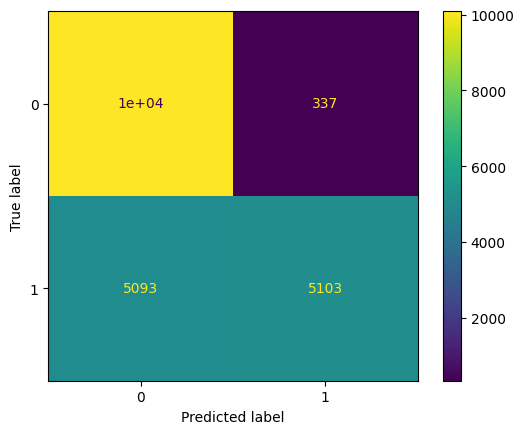

Test set:
Test precision risk: 0.038506417736289385
Test recall risk: 0.0691340782122905
Test f1 risk: 0.04946290282288285
              precision    recall  f1-score   support

           0       0.66      0.96      0.79      2571
           1       0.93      0.52      0.66      2586

    accuracy                           0.74      5157
   macro avg       0.80      0.74      0.72      5157
weighted avg       0.80      0.74      0.72      5157



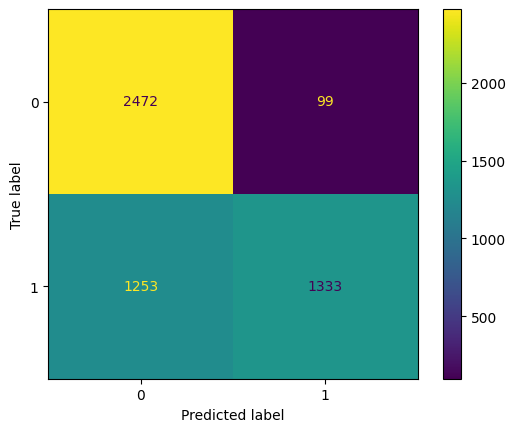

Registered model 'pls_v4' already exists. Creating a new version of this model...
2024/01/24 09:24:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pls_v4, version 2
Created version '2' of model 'pls_v4'.


############### n_component = 2 ###############
Train set:
Train precision risk: 0.06155911400901333
Train recall risk: 0.10842763046782639
Train f1 risk: 0.07853211009174313
              precision    recall  f1-score   support

           0       0.67      0.94      0.78     10429
           1       0.89      0.52      0.66     10196

    accuracy                           0.73     20625
   macro avg       0.78      0.73      0.72     20625
weighted avg       0.78      0.73      0.72     20625



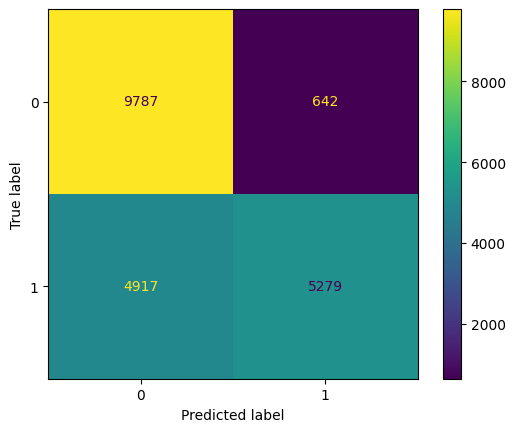

Test set:
Test precision risk: 0.07156748346946713
Test recall risk: 0.11794871794871795
Test f1 risk: 0.08908254659888647
              precision    recall  f1-score   support

           0       0.66      0.93      0.77      2571
           1       0.88      0.53      0.66      2586

    accuracy                           0.73      5157
   macro avg       0.77      0.73      0.72      5157
weighted avg       0.77      0.73      0.72      5157



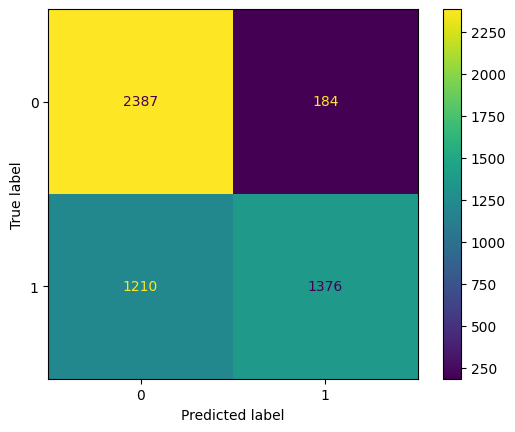

Successfully registered model 'pls_v5'.
2024/01/24 09:24:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pls_v5, version 1
Created version '1' of model 'pls_v5'.


############### n_component = 3 ###############
Train set:
Train precision risk: 0.09310576277687219
Train recall risk: 0.14239624578383928
Train f1 risk: 0.11259276437847868
              precision    recall  f1-score   support

           0       0.69      0.91      0.78     10429
           1       0.86      0.57      0.69     10196

    accuracy                           0.74     20625
   macro avg       0.77      0.74      0.73     20625
weighted avg       0.77      0.74      0.73     20625



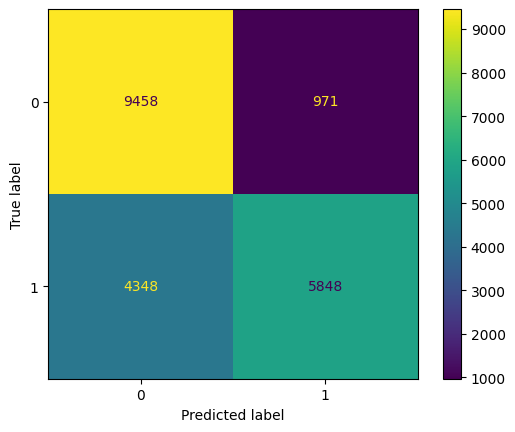

Test set:
Test precision risk: 0.09996110462854921
Test recall risk: 0.14569160997732428
Test f1 risk: 0.11856978085351788
              precision    recall  f1-score   support

           0       0.68      0.90      0.78      2571
           1       0.85      0.58      0.69      2586

    accuracy                           0.74      5157
   macro avg       0.77      0.74      0.73      5157
weighted avg       0.77      0.74      0.73      5157



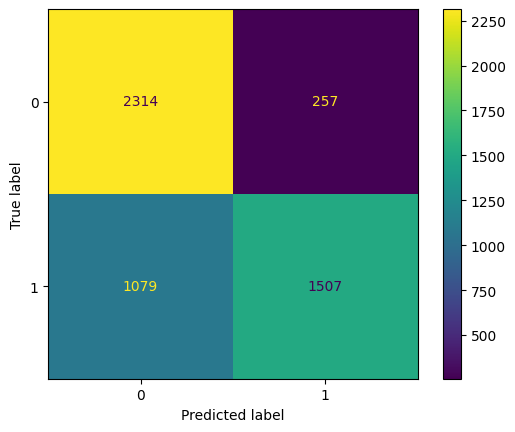

Successfully registered model 'pls_v6'.
2024/01/24 09:24:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pls_v6, version 1
Created version '1' of model 'pls_v6'.


############### n_component = 4 ###############
Train set:
Train precision risk: 0.10154377217374629
Train recall risk: 0.14997875655006374
Train f1 risk: 0.12109777015437392
              precision    recall  f1-score   support

           0       0.69      0.90      0.78     10429
           1       0.85      0.59      0.70     10196

    accuracy                           0.75     20625
   macro avg       0.77      0.74      0.74     20625
weighted avg       0.77      0.75      0.74     20625



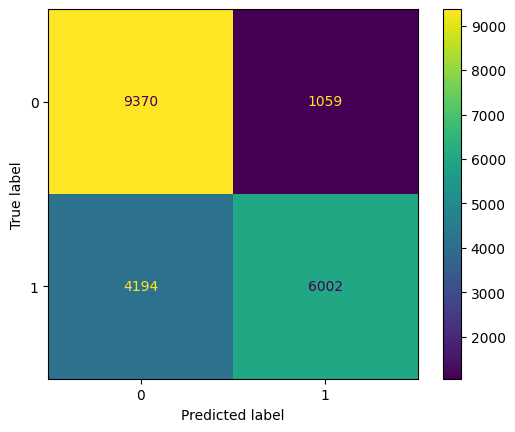

Test set:
Test precision risk: 0.10657331777518475
Test recall risk: 0.150384193194292
Test f1 risk: 0.12474391076712955
              precision    recall  f1-score   support

           0       0.69      0.89      0.78      2571
           1       0.85      0.60      0.70      2586

    accuracy                           0.75      5157
   macro avg       0.77      0.75      0.74      5157
weighted avg       0.77      0.75      0.74      5157



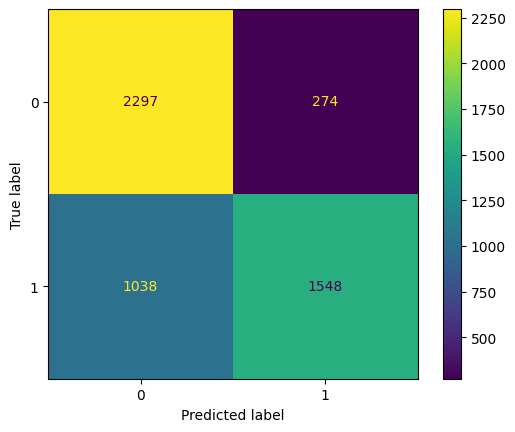

Successfully registered model 'pls_v7'.
2024/01/24 09:24:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pls_v7, version 1
Created version '1' of model 'pls_v7'.


In [36]:
threshold = 0.5
for n_component in [1, 2, 3, 4]:
    print(f'############### n_component = {n_component} ###############')
    pls_params = {'n_components': n_component}
    pls = Pipeline([
        ('scaler', RobustScaler()),
        ('pls', PLSRegression(**pls_params))
    ])
    cols = features
    train, test = X_train[cols], X_test[cols]
    pls.fit(train, y_train)
    
    y_pred_train = (pls.predict(train) > threshold).astype(int)
    
    
    print('Train set:')
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(f'Train precision risk: {precision_risk(cm_train)}')
    print(f'Train recall risk: {recall_risk(cm_train)}')
    print(f'Train f1 risk: {f1_risk(cm_train)}')
    print(classification_report(y_train, y_pred_train))
    ConfusionMatrixDisplay(cm_train).plot()
    plt.show()
    
    y_pred_test = (pls.predict(test) > threshold).astype(int)
    print('Test set:')
    cm_test = confusion_matrix(y_test, y_pred_test)
    pr_risk, rc_risk, fo_risk = precision_risk(cm_test), recall_risk(cm_test), f1_risk(cm_test)
    print(f'Test precision risk: {pr_risk}')
    print(f'Test recall risk: {rc_risk}')
    print(f'Test f1 risk: {fo_risk}')
    print(classification_report(y_test, y_pred_test))
    ConfusionMatrixDisplay(cm_test).plot()
    plt.show()

    # log the current model
    with mlflow.start_run():
        mlflow.log_params(pls_params)
        mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
        mlflow.set_tags({'Version': f'v{3+n_component}', 'Features': cols,'mlflow.note.content': f'PLS Regression with {n_component} components on the continuous features'})
        mlflow.sklearn.log_model(sk_model=pls, artifact_path='lr', input_example=train, registered_model_name=f'pls_v{3+n_component}')

First of all, there is no overfitting for any of these PLS models.  
We see that the risk of classifying a `No_Displ` product as `Displ` gets higher the more we increase the number of components. Meaning that we'd rather have a model with less components. (4 components lead to 277 fp and 981 fn, while 1 component leads to 87 fp and 1226 fn).  
However, we can't say that the model with 1 component is better, because it is actually not useful at all, since it is not able to classify any product as `Displ`.

### SVM

In [37]:
# create a new experiment for SVM
# mlflow.create_experiment('SVM', tags={'mlflow.note.content': 'Models based on SVM'})
mlflow.set_experiment('SVM')

<Experiment: artifact_location='mlflow-artifacts:/701476371900273425', creation_time=1706084824256, experiment_id='701476371900273425', last_update_time=1706084824256, lifecycle_stage='active', name='SVM', tags={'mlflow.note.content': 'Models based on SVM'}>

#### Using Continuous Variables

Train set:
Train Precision risk: 0.1220634768434174
Train Recall risk: 0.16247606892150607
Train F1 risk: 0.13939991239597022
              precision    recall  f1-score   support

           0       0.72      0.88      0.79     10429
           1       0.84      0.64      0.73     10196

    accuracy                           0.76     20625
   macro avg       0.78      0.76      0.76     20625
weighted avg       0.78      0.76      0.76     20625



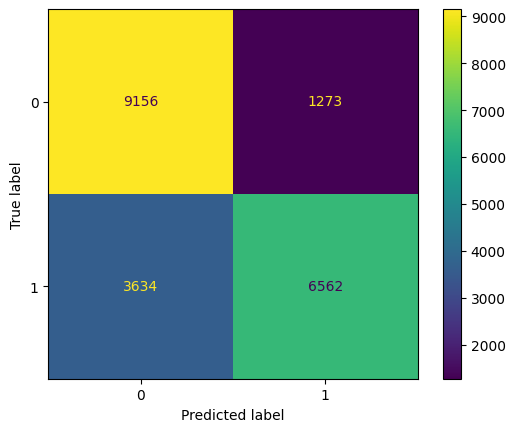

Test set:
Test Precision risk: 0.13263321664721897
Test Recall risk: 0.16764995083579154
Test F1 risk: 0.14809989142236699
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      2571
           1       0.83      0.65      0.73      2586

    accuracy                           0.76      5157
   macro avg       0.77      0.76      0.76      5157
weighted avg       0.77      0.76      0.76      5157



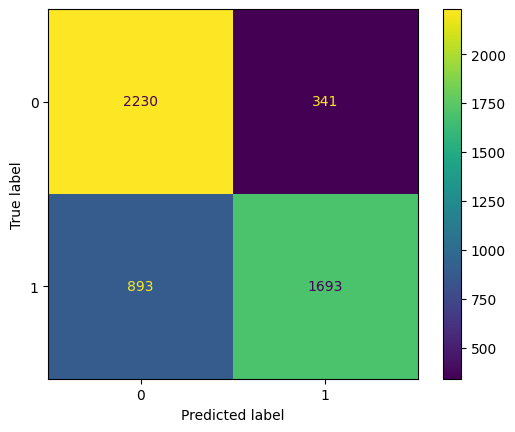

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'svm_v1'.
2024/01/24 12:57:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

In [38]:
svm_v1_params = {
    'random_state': 42
}
svm_v1 = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(**svm_v1_params))
])

cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(svm_v1, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params(svm_v1_params)
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v1', 'Features': cols,'mlflow.note.content': f'Default SVM model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=svm_v1, artifact_path='svm', input_example=train, registered_model_name=f'svm_v1')

This SVM model is both slow and not performing well compared to the logistic regression models, eventhough it has a good accuracy.

#### Using Discritized Variables

Train set:
Train Precision risk: 0.12484418448556908
Train Recall risk: 0.1590714722052535
Train F1 risk: 0.13989470291178682
              precision    recall  f1-score   support

           0       0.73      0.88      0.80     10429
           1       0.84      0.68      0.75     10196

    accuracy                           0.78     20625
   macro avg       0.79      0.78      0.77     20625
weighted avg       0.79      0.78      0.77     20625



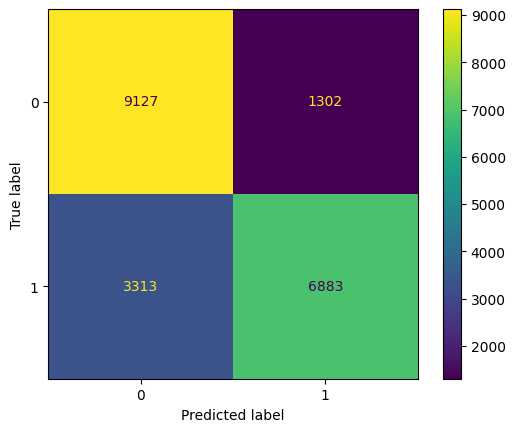

Test set:
Test Precision risk: 0.1306884480746791
Test Recall risk: 0.15954415954415954
Test F1 risk: 0.1436818473380372
              precision    recall  f1-score   support

           0       0.73      0.87      0.80      2571
           1       0.84      0.68      0.75      2586

    accuracy                           0.78      5157
   macro avg       0.79      0.78      0.77      5157
weighted avg       0.79      0.78      0.77      5157



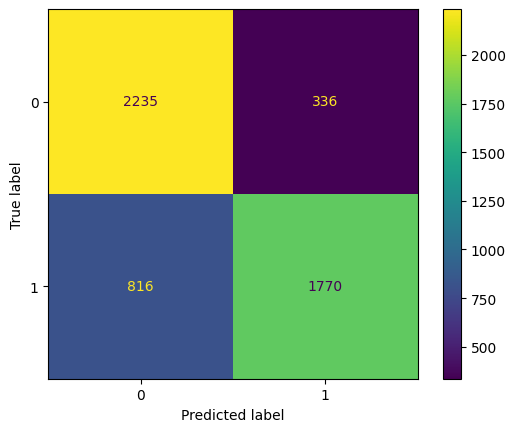

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'svm_v2'.
2024/01/24 13:00:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

In [39]:
svm_v2_params = {
    'random_state': 42
}
svm_v2 = SVC(**svm_v2_params)
cols = features_disc
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(svm_v2, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params(svm_v2_params)
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v2', 'Features': cols, 'mlflow.note.content': f'Default SVM model on the discretized features'})
    mlflow.sklearn.log_model(sk_model=svm_v2, artifact_path='svm', input_example=train, registered_model_name=f'svm_v2')

Using the discrete feature, the model becomes better overall (accuracy).

#### Using PCA

PCA is a good method that creates new features that are uncorrelated, we can then build the SVM model on these new features.

Train set:
Train Precision risk: 0.08610605043628344
Train Recall risk: 0.1657438169066076
Train F1 risk: 0.11333375402284344
              precision    recall  f1-score   support

           0       0.63      0.91      0.74     10429
           1       0.83      0.44      0.58     10196

    accuracy                           0.68     20625
   macro avg       0.73      0.68      0.66     20625
weighted avg       0.73      0.68      0.66     20625



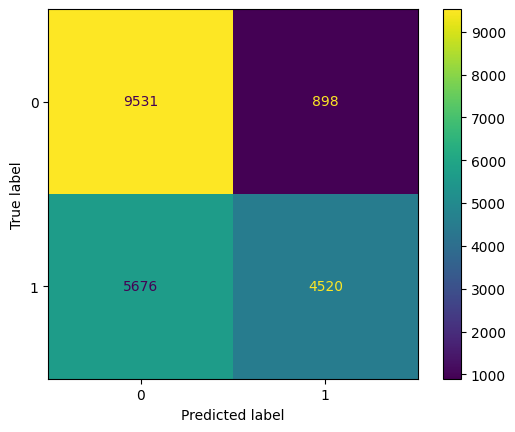

Test set:
Test Precision risk: 0.08907040062232595
Test Recall risk: 0.16368834882058614
Test F1 risk: 0.11536523929471033
              precision    recall  f1-score   support

           0       0.62      0.91      0.74      2571
           1       0.84      0.45      0.59      2586

    accuracy                           0.68      5157
   macro avg       0.73      0.68      0.66      5157
weighted avg       0.73      0.68      0.66      5157



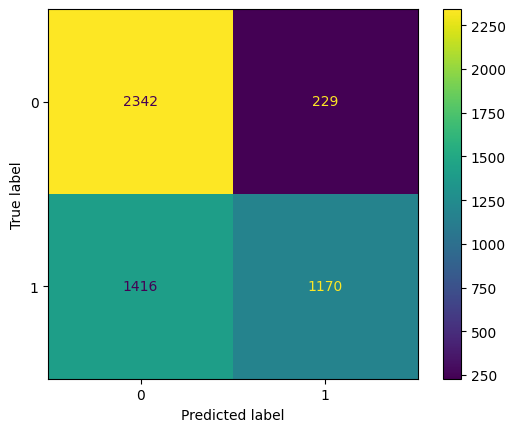

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'svm_v3'.
2024/01/24 13:04:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

In [41]:
svm_v3 = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', SVC())
])
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(svm_v3, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params({'n_components': 0.95})
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v3', 'Features': cols, 'mlflow.note.content': f'SVM model with PCA on the continuous features'})
    mlflow.sklearn.log_model(sk_model=svm_v3, artifact_path='svm', input_example=train, registered_model_name=f'svm_v3')

The accuracy of the model is the worst among all the models that we tried, and it is also very slow.

### Decision Tree

The decision tree model doesn't need discretized features, because by default, it uses the Gini impurity criterion to split the continuous features.

In [42]:
# create a new experiment for Tree-based models
# mlflow.create_experiment('Trees', tags={'mlflow.note.content': 'Tree-based models'})
mlflow.set_experiment('Trees')

<Experiment: artifact_location='mlflow-artifacts:/936349254237143598', creation_time=1706097984573, experiment_id='936349254237143598', last_update_time=1706097984573, lifecycle_stage='active', name='Trees', tags={'mlflow.note.content': 'Tree-based models'}>

Train set:
Train Precision risk: 0.0011506376450282866
Train Recall risk: 0.0011816838995568684
Train F1 risk: 0.001165954139137194
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10429
           1       1.00      0.99      1.00     10196

    accuracy                           1.00     20625
   macro avg       1.00      1.00      1.00     20625
weighted avg       1.00      1.00      1.00     20625



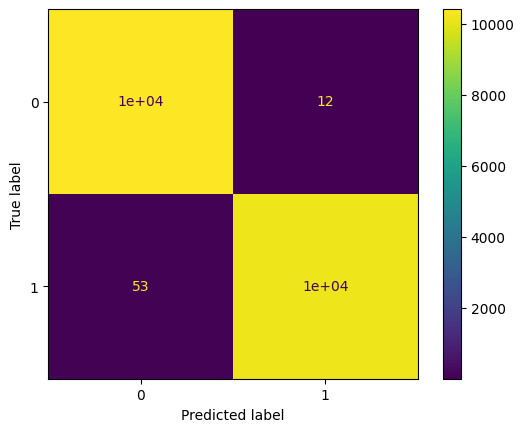

Test set:
Test Precision risk: 0.21664721898094128
Test Recall risk: 0.20690936106983654
Test F1 risk: 0.21166634999049974
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2571
           1       0.79      0.83      0.81      2586

    accuracy                           0.80      5157
   macro avg       0.81      0.80      0.80      5157
weighted avg       0.81      0.80      0.80      5157



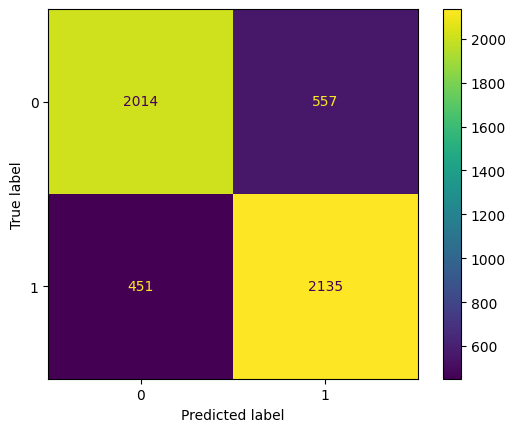

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'dt_v1'.
2024/01/24 13:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

In [43]:
dt_v1 = DecisionTreeClassifier()
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(dt_v1, train, test, y_train, y_test)

with mlflow.start_run():
    # mlflow.log_params({})
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v1', 'Features': cols, 'mlflow.note.content': f'Default Decision Tree model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=dt_v1, artifact_path='dt', input_example=train, registered_model_name=f'dt_v1')

The decision tree model overfits the data, we will have to tune its hyperparameters to reduce the overfitting.

Train set:
Train Precision risk: 0.07095598811007767
Train Recall risk: 0.09544692377144331
Train F1 risk: 0.08139918600813992
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     10429
           1       0.90      0.69      0.78     10196

    accuracy                           0.81     20625
   macro avg       0.83      0.81      0.81     20625
weighted avg       0.83      0.81      0.81     20625



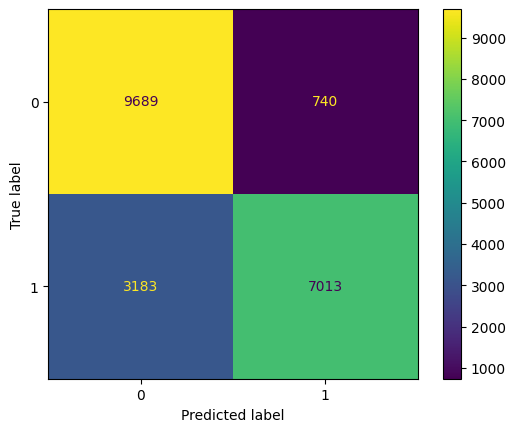

Test set:
Test Precision risk: 0.10423959548813691
Test Recall risk: 0.13440320962888666
Test F1 risk: 0.11741511500547645
              precision    recall  f1-score   support

           0       0.73      0.90      0.80      2571
           1       0.87      0.67      0.75      2586

    accuracy                           0.78      5157
   macro avg       0.80      0.78      0.78      5157
weighted avg       0.80      0.78      0.78      5157



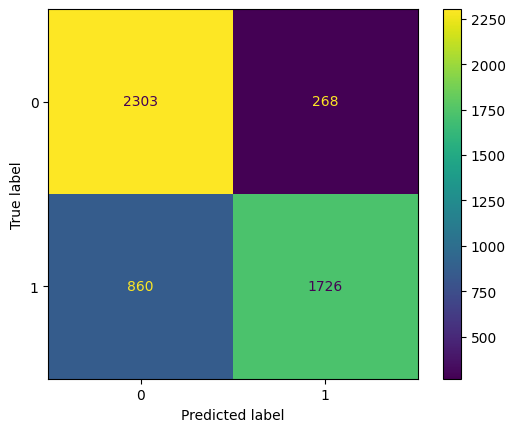

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'dt_v2'.
2024/01/24 13:08:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

In [44]:
dt_v2_params = {
    'max_depth': 10
}
dt_v2 = DecisionTreeClassifier(**dt_v2_params)
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(dt_v2, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params(dt_v2_params)
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v2', 'Features': cols, 'mlflow.note.content': f'Regularized decision tree model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=dt_v2, artifact_path='dt', input_example=train, registered_model_name=f'dt_v2')

We have been able to reduce overfitting only by controlling the depth of the tree. Our model is better than the previous ones, it works well with both classes, and it has a low risk.

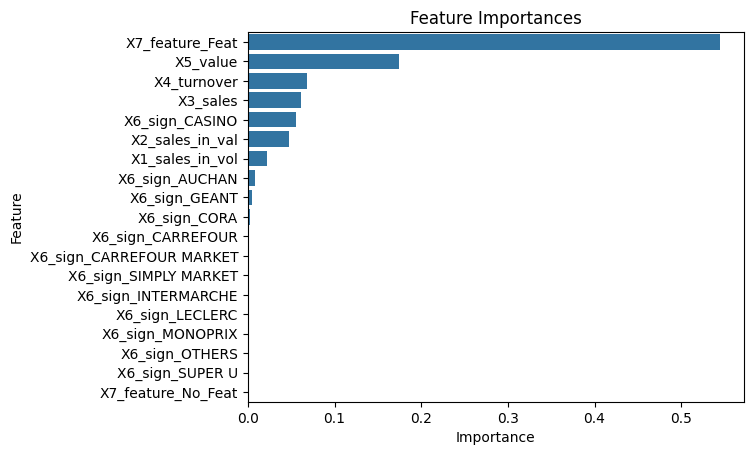

In [45]:
# plot feature importance
sns.barplot(
    data=pd.DataFrame(dt_v2.feature_importances_, columns=['Importance'], index=cols),
    x='Importance',
    y=cols,
    order=pd.DataFrame(dt_v2.feature_importances_, columns=['Importance'], index=cols).sort_values(by='Importance', ascending=False).index
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

`X7` is the first feature used to construct the tree, this is a binary feature, that's why one category is the most important and the other is the least, because once the split is done, we do not need to use the other category anymore.

### Random Forest

In [41]:
# create experiment for ensembles
# mlflow.create_experiment('Ensembles', tags={'mlflow.note.content': 'Ensemble models'})
mlflow.set_experiment('Ensembles')

<Experiment: artifact_location='mlflow-artifacts:/140588233033326834', creation_time=1706098186283, experiment_id='140588233033326834', last_update_time=1706098186283, lifecycle_stage='active', name='Ensembles', tags={'mlflow.note.content': 'Ensemble models'}>

Train set:
Train Precision risk: 0.004123118228018027
Train Recall risk: 0.004208671821474014
Train F1 risk: 0.004165455778359003
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10429
           1       1.00      1.00      1.00     10196

    accuracy                           1.00     20625
   macro avg       1.00      1.00      1.00     20625
weighted avg       1.00      1.00      1.00     20625



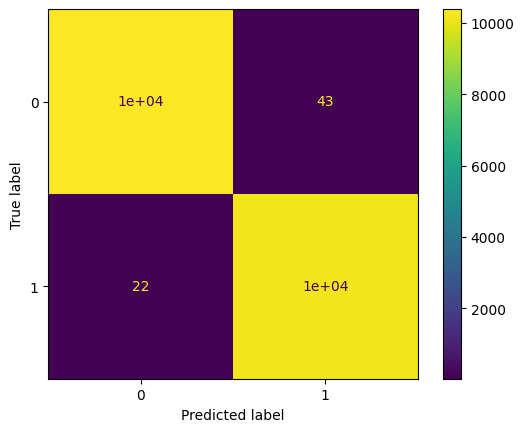

Test set:
Test Precision risk: 0.14157915208090238
Test Recall risk: 0.14467408585055644
Test F1 risk: 0.14310988794967563
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2571
           1       0.86      0.83      0.84      2586

    accuracy                           0.85      5157
   macro avg       0.85      0.85      0.85      5157
weighted avg       0.85      0.85      0.85      5157



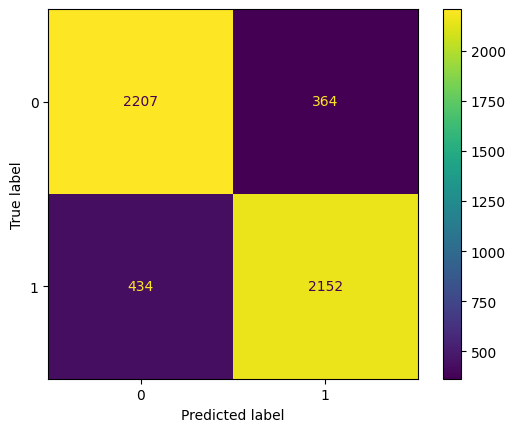

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'rf_v1'.
2024/01/24 13:10:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

In [47]:
rf_v1 = RandomForestClassifier()
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(rf_v1, train, test, y_train, y_test)

with mlflow.start_run():
    # mlflow.log_params({})
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v1', 'Features': cols, 'mlflow.note.content': f'Default Random Forest model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=rf_v1, artifact_path='rf', input_example=train, registered_model_name=f'rf_v1')

Bad overfitting !!!

Train set:
Train Precision risk: 0.07757215456899032
Train Recall risk: 0.10334695963208994
Train F1 risk: 0.08862354165525552
              precision    recall  f1-score   support

           0       0.75      0.92      0.83     10429
           1       0.90      0.69      0.78     10196

    accuracy                           0.81     20625
   macro avg       0.82      0.81      0.80     20625
weighted avg       0.82      0.81      0.80     20625



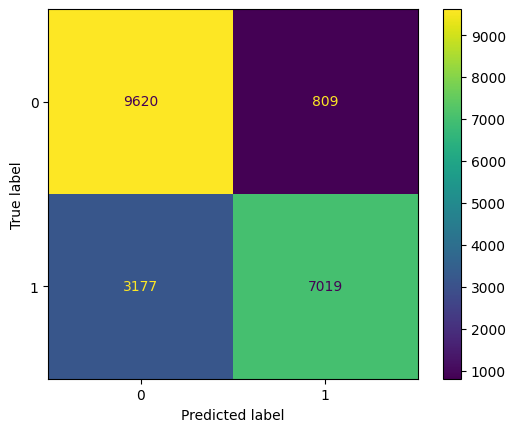

Test set:
Test Precision risk: 0.09568261376896149
Test Recall risk: 0.12130177514792899
Test F1 risk: 0.10697977821265492
              precision    recall  f1-score   support

           0       0.74      0.90      0.82      2571
           1       0.88      0.69      0.77      2586

    accuracy                           0.80      5157
   macro avg       0.81      0.80      0.79      5157
weighted avg       0.81      0.80      0.79      5157



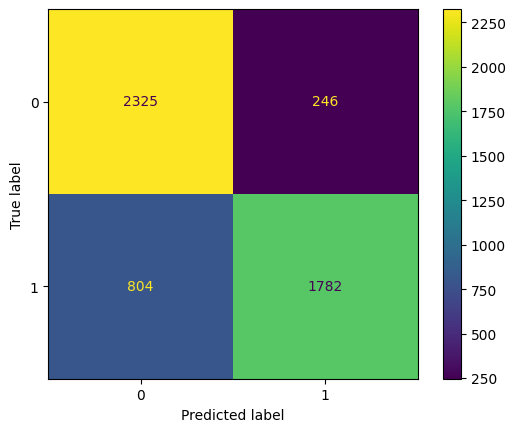

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'rf_v2'.
2024/01/24 13:11:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

In [48]:
rf_v2_params = {
    'max_depth': 10
}
rf_v2 = RandomForestClassifier(**rf_v2_params)
cols = features
train, test = X_train[cols], X_test[cols]
pr_risk, rc_risk, fo_risk = train_and_evaluate(rf_v2, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params(rf_v2_params)
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v2', 'Features': cols, 'mlflow.note.content': f'Regularized Random Forest model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=rf_v2, artifact_path='rf', input_example=train, registered_model_name=f'rf_v2')

Compared to the Decision Tree model, the Random Forest model does a better job at reducing the overfitting, and it reduces both the risk and error.

### Gradient Boosting using XGBoost

Train set:
Train Precision risk: 0.0767091763352191
Train Recall risk: 0.08399832003359933
Train F1 risk: 0.0801884428406756
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     10429
           1       0.92      0.86      0.88     10196

    accuracy                           0.89     20625
   macro avg       0.89      0.89      0.89     20625
weighted avg       0.89      0.89      0.89     20625



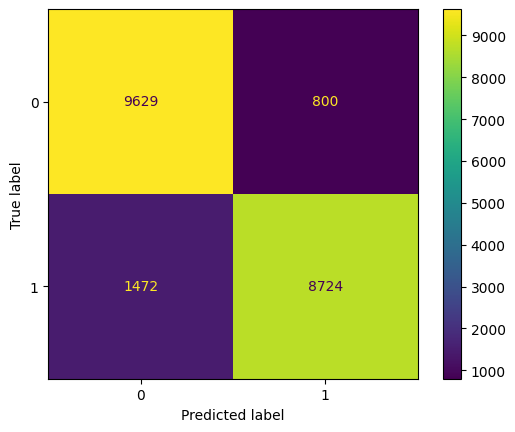

Test set:
Test Precision risk: 0.13185530921820304
Test Recall risk: 0.13882063882063883
Test F1 risk: 0.13524835427887494
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2571
           1       0.86      0.81      0.84      2586

    accuracy                           0.84      5157
   macro avg       0.84      0.84      0.84      5157
weighted avg       0.84      0.84      0.84      5157



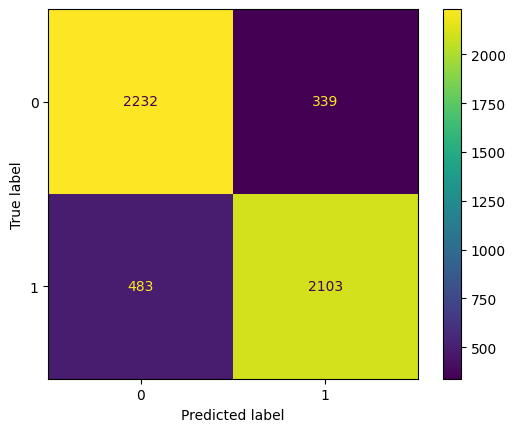

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'xgb_v1'.
2024/01/24 13:13:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

In [49]:
xgb_v1 = xgb.XGBClassifier()
cols = features
train, test = X_train[cols], X_test[cols]

pr_risk, rc_risk, fo_risk = train_and_evaluate(xgb_v1, train, test, y_train, y_test)

with mlflow.start_run():
    # mlflow.log_params({})
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v3', 'Features': cols, 'mlflow.note.content': f'Default XGBoost model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=xgb_v1, artifact_path='xgb', input_example=train, registered_model_name=f'xgb_v1')

It's normal for these models to overfit the data, since these models learn very complex functions and representations of the data. That's why we will always have to tune their hyperparameters.  
The XGBoost model however, does't overfit as much as the random forest, which is a good sign.

In [51]:
# define the parameter grid
param_grid = {
    'n_estimators': [150, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [1, 0.1, 0.01],
    'reg_lambda': [1, 0.1, 0.01],
    'reg_alpha': [1, 0.1, 0.01],
    'colsample_bytree': [0.8, 0.9, 1]
}

xgb_v2 = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = RandomizedSearchCV(estimator=xgb_v2, param_distributions=param_grid, scoring='f1', n_iter=30, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best Parameters:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1}
Best Score:  0.83641586329342


Train set:
Train Precision risk: 0.0578195416626714
Train Recall risk: 0.07366235035426337
Train F1 risk: 0.06478646253021755
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     10429
           1       0.93      0.74      0.83     10196

    accuracy                           0.84     20625
   macro avg       0.86      0.84      0.84     20625
weighted avg       0.86      0.84      0.84     20625



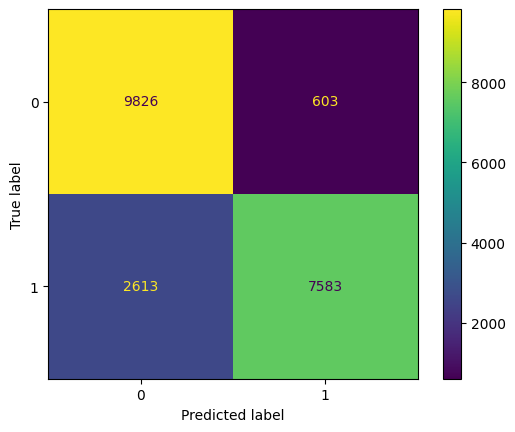

Test set:
Test Precision risk: 0.09762738234150137
Test Recall risk: 0.11867612293144209
Test F1 risk: 0.1071276141698677
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      2571
           1       0.88      0.72      0.79      2586

    accuracy                           0.81      5157
   macro avg       0.82      0.81      0.81      5157
weighted avg       0.82      0.81      0.81      5157



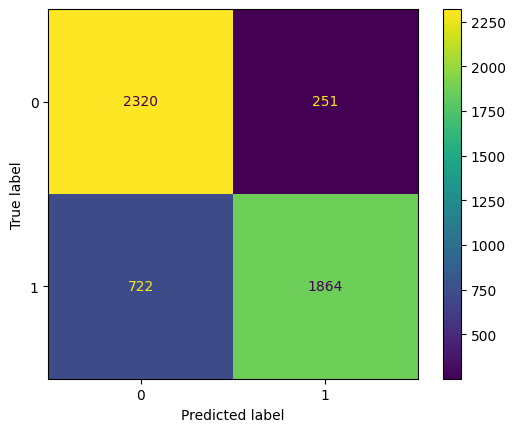

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'xgb_v2'.
2024/01/24 13:39:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

In [50]:
xgb_v2_params = {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'colsample_bytree': 0.8}
xgb_v2 = xgb.XGBClassifier(**xgb_v2_params)
cols = features
train, test = X_train[cols], X_test[cols]

pr_risk, rc_risk, fo_risk = train_and_evaluate(xgb_v2, train, test, y_train, y_test)

with mlflow.start_run():
    mlflow.log_params(xgb_v2_params)
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v4', 'Features': cols, 'mlflow.note.content': f'Optimized XGBoost model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=xgb_v2, artifact_path='xgb', input_example=train, registered_model_name=f'xgb_v2')

After a few rounds of hyperparameter tuning, we were able to reduce the overfitting and have a model that is better at reducing the risk, while doing a good job at reducing the error as well.

### Gradient Boosting using CatBoost

Learning rate set to 0.037513
0:	learn: 0.6748104	total: 5.41ms	remaining: 5.41s
1:	learn: 0.6581341	total: 9.81ms	remaining: 4.89s
2:	learn: 0.6434226	total: 14.8ms	remaining: 4.93s
3:	learn: 0.6293783	total: 19.9ms	remaining: 4.95s
4:	learn: 0.6164774	total: 23.9ms	remaining: 4.76s
5:	learn: 0.6048236	total: 28.3ms	remaining: 4.68s
6:	learn: 0.5947871	total: 31.7ms	remaining: 4.5s
7:	learn: 0.5854946	total: 35.2ms	remaining: 4.36s
8:	learn: 0.5767759	total: 39.3ms	remaining: 4.33s
9:	learn: 0.5691703	total: 43.5ms	remaining: 4.3s
10:	learn: 0.5618827	total: 47.3ms	remaining: 4.25s
11:	learn: 0.5549256	total: 52ms	remaining: 4.28s
12:	learn: 0.5493369	total: 55.8ms	remaining: 4.24s
13:	learn: 0.5436115	total: 60.2ms	remaining: 4.24s
14:	learn: 0.5387611	total: 64.6ms	remaining: 4.24s
15:	learn: 0.5340433	total: 69.4ms	remaining: 4.27s
16:	learn: 0.5298685	total: 73.7ms	remaining: 4.26s
17:	learn: 0.5259965	total: 79.8ms	remaining: 4.35s
18:	learn: 0.5223202	total: 83.8ms	remaining: 4.

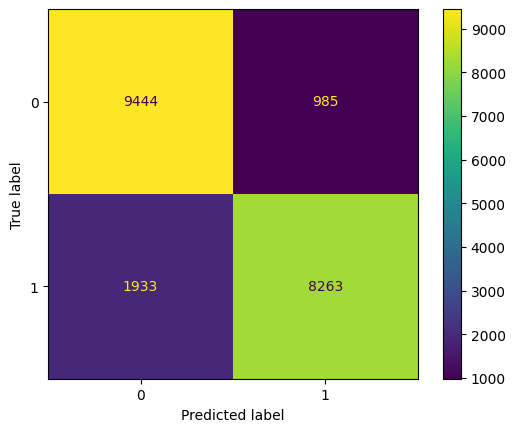

Test set:
Test Precision risk: 0.11979774406845585
Test Recall risk: 0.12973883740522324
Test F1 risk: 0.12457027300303336
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2571
           1       0.87      0.80      0.83      2586

    accuracy                           0.84      5157
   macro avg       0.84      0.84      0.84      5157
weighted avg       0.84      0.84      0.84      5157



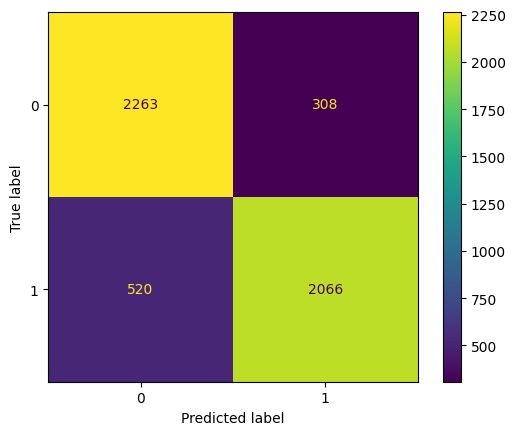

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings

In [11]:
cb_v1 = cb.CatBoostClassifier()
cols = features
train, test = X_train[cols], X_test[cols]

pr_risk, rc_risk, fo_risk = train_and_evaluate(cb_v1, train, test, y_train, y_test)

with mlflow.start_run():
    # mlflow.log_params({})
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    mlflow.set_tags({'Version': 'v5', 'Features': cols, 'mlflow.note.content': f'Default CatBoost model on the continuous features'})
    mlflow.sklearn.log_model(sk_model=cb_v1, artifact_path='cb', input_example=train, registered_model_name=f'cb_v1')

Catboost's default parameters are good if we were to look at the accuracy of the model. The model doesn't overfit the data. We can change the default classification threshold to achieve a better performance regarding the risk.

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2571
           1       0.89      0.76      0.82      2586

    accuracy                           0.83      5157
   macro avg       0.84      0.83      0.83      5157
weighted avg       0.84      0.83      0.83      5157

Test precision risk: 0.09607156748346947
Test recall risk: 0.11166365280289331
Test f1 risk: 0.1032824587079239


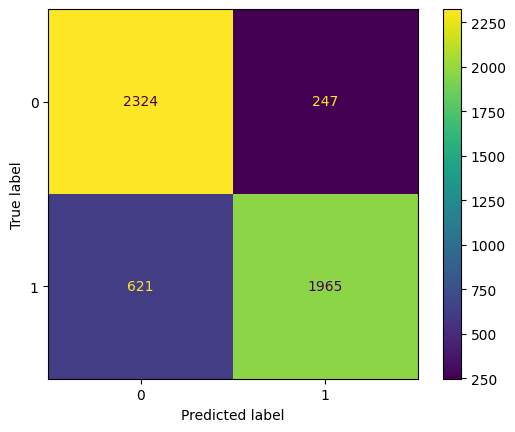

In [18]:
probs = cb_v1.predict_proba(test)
predictions = (probs[:, 1] >= 0.55).astype(int)
print(classification_report(y_test, predictions))
cm_test = confusion_matrix(y_test, predictions)
pr_risk, rc_risk, fo_risk = precision_risk(cm_test), recall_risk(cm_test), f1_risk(cm_test)
print(f'Test precision risk: {pr_risk}')
print(f'Test recall risk: {rc_risk}')
print(f'Test f1 risk: {fo_risk}')
ConfusionMatrixDisplay(cm_test).plot()

Best model so far, it has the lowest risk and error.

### Neural Network

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense_6 (Dense)             (None, 32)                640       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1185 (4.63 KB)
Trainable params: 1185 (4.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
516/516 [==============================] - 2s 2ms/step - loss: 39.0911 - accuracy: 0.5738 - val_loss: 23.9079 - val_accuracy: 0.6436
Epoch 2/20
516/516 [==============================] - 1s 2ms/step - loss: 27.9220 - accuracy: 0.6031 - val_loss: 158.3568 - val_accuracy: 0.4933
Epoch 3/20
516/516 [==============================] - 1s 2ms/step - loss: 22.6854 - accuracy: 0.6092 - val_loss: 10.4963 - val_accuracy: 0.5314
Ep

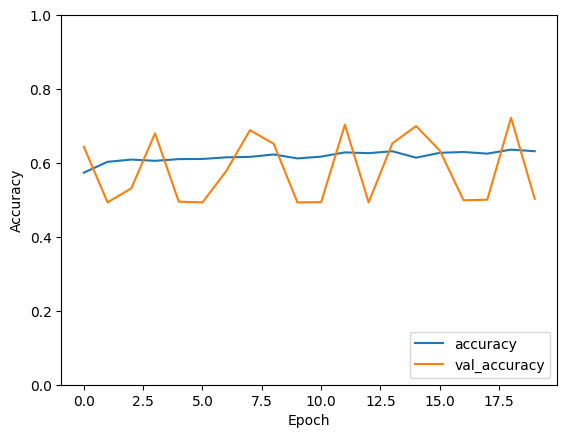

In [22]:
model = Sequential()
model.add(tfl.Dense(32, activation='relu', input_shape=(19,)))
model.add(tfl.Dense(16, activation='relu'))
model.add(tfl.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

cols = features
X_train, X_test = X_train[cols], X_test[cols]

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

It seems that the neural network model is not able to learn the data, the accuracy is increasing very slowly. This is normal, because we have a small dataset, and we are using a very simple model.

## Conclusion

After applying all of these models, we can conclude that the best one is the Gradient Boosting model using Catboost, as it has the lowest risk (247 FP), and the lowest error (621 FN).  
The model is also very fast to train and predict, and it doesn't overfit the data.  
The accuracy the model has is the highest. All that is left to do is to tune the classification threshold to reduce the risk even more, depending on the needs of the business.

In [43]:
# search runs from the current experiment
ensembles_df = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name('Ensembles').experiment_id)
run_id = ensembles_df.loc[ensembles_df['tags.Version']=='v5', 'run_id'].values[0]
print(run_id)

4d7051ac23a94172847f29433e1d3040


We can move to the model deployment phase.